<h1>Part 1: Summary Statistics and Plots

<h3>Subpart 1: Profit Margins by Store

In [1]:
# Import data
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker

data = pd.read_csv("data.csv").set_index(["Location number", "Month"])
data.head()

State  Gross revenue   Fixed cost  Variable cost  \
Location number Month                                                    
1               1        TX    48628171.02   9218156.69    24278189.23   
                2        TX    48107179.24  10587747.35    25116844.41   
                3        TX    64352278.29  10193873.77    33703499.83   
                4        TX    45943677.96   8764165.00    24037719.47   
                5        TX    32761434.98   8022116.43    16432119.18   

                       Rental cost  Number of products  Owned  
Location number Month                                          
1               1           365880                4452  False  
                2           365880                4452  False  
                3           365880                4452  False  
                4           365880                4452  False  
                5           365880                4452  False

In [2]:
# Sum revenues and costs across months
data_annual = data.groupby(["Location number", "State", "Number of products", "Owned"]).sum()
data_annual = data_annual.reset_index().set_index("Location number")
data_annual.head()

,State,Number of products,Owned,Gross revenue,Fixed cost,Variable cost,Rental cost
Location number,,,,,,,
1,TX,4452,False,5.447389e+08,1.108956e+08,2.793687e+08,4390560
2,TX,4502,False,3.559730e+08,7.287395e+07,1.937291e+08,783240
3,IL,4620,True,3.317718e+08,6.429775e+07,1.848279e+08,0
4,GA,4481,False,2.639843e+08,6.410409e+07,1.432398e+08,1696920
5,NJ,4533,False,1.890016e+08,4.475050e+07,1.037553e+08,894000


In [17]:
# Calculate annual profit margins, and find mean/median
data_annual["Profit margin"] = (data_annual["Gross revenue"] - data_annual["Fixed cost"] - data_annual["Variable cost"] - data_annual["Rental cost"]) / data_annual["Gross revenue"]
print("Mean annual profit margin: ", "{:2.2f}%".format(100 * data_annual["Profit margin"].mean()))
print("Median annual profit margin: ", "{:2.2f}%".format(100 * data_annual["Profit margin"].median()))

Mean annual profit margin:  24.86%
Median annual profit margin:  26.18%


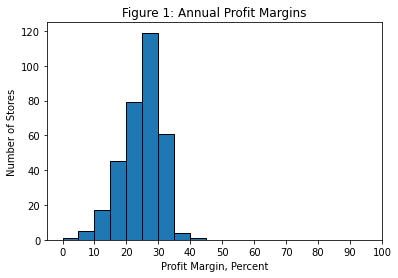

In [4]:
# Plot histogram of annual profit margins
fig, ax = plt.subplots()
ax.hist(100 * data_annual["Profit margin"], bins = range(0, 100, 5), edgecolor='black')
ax.set_xticks(range(0, 101, 10))
ax.set_title("Figure 1: Annual Profit Margins")
ax.set_xlabel("Profit Margin, Percent")
ax.set_ylabel("Number of Stores")
plt.show()

While the distribution of annual profit margins does have a clear peak, it is somewhat skewed left. This is also reflected by the fact that the mean is slightly less than the median. Still, the profit margins across locations look reasonably normally distributed. 

It is to be expected that the profit margins are bound between 0 and 50%. Even a highly profitable store is unable to generate revenue without incurring corresponding costs; hence, no stores have a profit margin above 50%, and very few have a profit margin above 35%. On the other hand, the least profitable stores are likely to be closed; indeed, we see that no stores have a negative profit margin, and very few have a profit margin below 10%. These factors likely contribute to the Gaussian shape of the distribution.

<h3>Subpart 2: Aggregate Revenue

In [5]:
# Sum revenues and costs across stores
data_aggregate_monthly = data.groupby("Month").sum()
data_aggregate_monthly.head()

,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned
Month,,,,,,
1,9.304129e+09,2.069499e+09,4.943004e+09,49191170,1502156,36.0
2,9.786843e+09,1.964354e+09,5.180280e+09,49191170,1502156,36.0
3,1.158736e+10,2.296857e+09,6.126065e+09,49191170,1502156,36.0
4,9.105208e+09,1.915483e+09,4.754642e+09,49191170,1502156,36.0
5,9.347461e+09,1.877253e+09,4.860179e+09,49191170,1502156,36.0


In [6]:
# Combine months into quarters
data_aggregate_quarterly = data_aggregate_monthly.copy()
data_aggregate_quarterly.insert(0, "Quarter", [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4])
data_aggregate_quarterly = data_aggregate_quarterly.groupby("Quarter").sum()
data_aggregate_quarterly.head()

,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned
Quarter,,,,,,
1,3.067833e+10,6.330709e+09,1.624935e+10,147573510,4506468,108.0
2,2.975031e+10,6.168927e+09,1.546212e+10,147573510,4506468,108.0
3,2.988107e+10,6.241126e+09,1.536014e+10,147573510,4506468,108.0
4,2.993717e+10,6.227698e+09,1.583052e+10,147573510,4506468,108.0


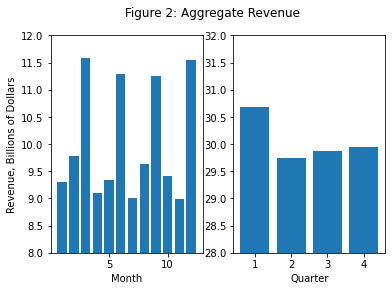

In [7]:
# Visualize monthly and quarterly aggregate revenue
fig, (ax1, ax2) = plt.subplots(ncols = 2)
plt.suptitle("Figure 2: Aggregate Revenue")
ax1.set_ylabel("Revenue, Billions of Dollars")

ax1.bar(data_aggregate_monthly.index, data_aggregate_monthly["Gross revenue"] / 10 ** 9)
ax1.set_ylim(8, 12)
ax1.set_xlabel("Month")

ax2.bar(data_aggregate_quarterly.index, data_aggregate_quarterly["Gross revenue"] / 10 ** 9)
ax2.set_ylim(28, 32)
ax2.set_xlabel("Quarter")

plt.show()

Note that we are assuming use of monthly and quarterly aggregate *gross* revenue, so costs are not included.

<h1>Part 2: Data Cleaning

In [134]:
# Ensure that all owned stores are in states where there are also leased stores
data_leased = data[~data["Owned"]].copy()
data_owned = data[data["Owned"]].copy()
print(sorted(data_leased["State"].unique()))
print(sorted(data_owned["State"].unique()))

['CA', 'CO', 'GA', 'IL', 'NJ', 'TX', 'WA']
['CA', 'CO', 'GA', 'IL', 'NJ', 'TX', 'WA']


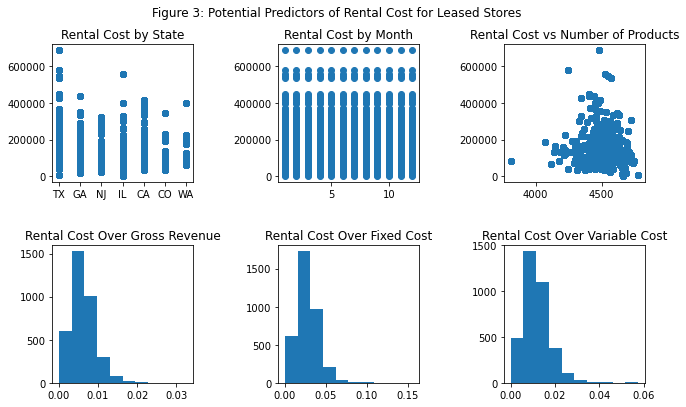

In [135]:
# Explore different possible predictors of rental cost
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(10,6))
plt.suptitle("Figure 3: Potential Predictors of Rental Cost for Leased Stores")
axs[0, 0].scatter(data_leased["State"], data_leased["Rental cost"])
axs[0, 0].set_title("Rental Cost by State")
axs[0, 1].scatter(data_leased.index.get_level_values("Month"), data_leased["Rental cost"])
axs[0, 1].set_title("Rental Cost by Month")
axs[0, 2].scatter(data_leased["Number of products"], data_leased["Rental cost"])
axs[0, 2].set_title("Rental Cost vs Number of Products")
axs[1, 0].hist(data_leased["Rental cost"] / data_leased["Gross revenue"])
axs[1, 0].set_title("Rental Cost Over Gross Revenue")
axs[1, 1].hist(data_leased["Rental cost"] / data_leased["Fixed cost"])
axs[1, 1].set_title("Rental Cost Over Fixed Cost")
axs[1, 2].hist(data_leased["Rental cost"] / data_leased["Variable cost"])
axs[1, 2].set_title("Rental Cost Over Variable Cost")
fig.tight_layout(pad = 3)
plt.show()

Notice that rental costs appear to vary by state (though the range is extensive), but the relationship between rental cost and number of products is highly unclear. Furthermore, while there may be valuable information in the ratio of rental cost to other store metrics, using gross revenue, fixed cost, and variable cost, as that metric all appear to yield similar results. Finally, rental costs are constant each month.

As such, we will impute projected monthly rental costs for owned locations as the mean monthly gross revenue for the owned location, multiplied by the median ratio of monthly rental cost to mean gross revenue for leased stores in the state.

In [136]:
# Calculate median monthly rental cost to mean gross revenue ratios for each state
data_leased = data_leased.groupby(["Location number", "State"]).mean()
data_leased["Ratio"] = data_leased["Rental cost"] / data_leased["Gross revenue"]
data_leased = data_leased.groupby("State").median()
data_leased.head()

,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,Ratio
State,,,,,,,
CA,2.689431e+07,5.524292e+06,1.378571e+07,139615,4491,False,0.006203
CO,2.670831e+07,5.912333e+06,1.470574e+07,135750,4511,False,0.004982
GA,2.202021e+07,5.173485e+06,1.202373e+07,134910,4502,False,0.005641
IL,2.403461e+07,5.468111e+06,1.313542e+07,140265,4516,False,0.006114
NJ,2.237595e+07,5.121991e+06,1.270802e+07,146390,4505,False,0.006744


In [137]:
# Calculate mean monthly gross revenues for owned stores
data_owned = data_owned.groupby("Location number").mean()
data_owned.head()

,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned
Location number,,,,,,
3,2.764765e+07,5.358146e+06,1.540232e+07,0,4620,True
9,6.774316e+07,1.169296e+07,3.150183e+07,0,4789,True
11,2.571321e+07,5.376977e+06,1.393406e+07,0,4568,True
21,2.663192e+07,5.415316e+06,1.363053e+07,0,4594,True
31,3.016265e+07,5.271787e+06,1.575493e+07,0,4666,True


In [138]:
# Impute rental costs for owned stores using the ratio above
data_imputed = data.copy()
data_imputed["Rental cost"] = data_imputed.apply(
    lambda row: data_owned.loc[row.name[0], "Gross revenue"] * data_leased.loc[row["State"], "Ratio"] if row["Owned"] else row["Rental cost"],
    axis=1
)
data_imputed.loc[data_imputed["Owned"]].head()

State  Gross revenue  Fixed cost  Variable cost  \
Location number Month                                                   
3               1        IL    30791018.69  6123108.00    17948338.14   
                2        IL    23805331.16  5014361.53    13051817.38   
                3        IL    33916624.99  6043273.71    19190769.99   
                4        IL    24170582.83  5196755.17    13505396.58   
                5        IL    24925332.00  4688566.82    14531349.44   

                        Rental cost  Number of products  Owned  
Location number Month                                           
3               1      169040.84003                4620   True  
                2      169040.84003                4620   True  
                3      169040.84003                4620   True  
                4      169040.84003                4620   True  
                5      169040.84003                4620   True

In [139]:
# Sum revenues and costs across months again
data_imputed_annual = data_imputed.groupby(["Location number", "State", "Number of products", "Owned"]).sum()
data_imputed_annual = data_imputed_annual.reset_index().set_index("Location number")
data_imputed_annual.head()

,State,Number of products,Owned,Gross revenue,Fixed cost,Variable cost,Rental cost
Location number,,,,,,,
1,TX,4452,False,5.447389e+08,1.108956e+08,2.793687e+08,4.390560e+06
2,TX,4502,False,3.559730e+08,7.287395e+07,1.937291e+08,7.832400e+05
3,IL,4620,True,3.317718e+08,6.429775e+07,1.848279e+08,2.028490e+06
4,GA,4481,False,2.639843e+08,6.410409e+07,1.432398e+08,1.696920e+06
5,NJ,4533,False,1.890016e+08,4.475050e+07,1.037553e+08,8.940000e+05


In [140]:
# Recalculate rent-adjusted annual profit margins, and find mean/median
data_imputed_annual["Profit margin"] = (data_imputed_annual["Gross revenue"] - data_imputed_annual["Fixed cost"] - data_imputed_annual["Variable cost"] - data_imputed_annual["Rental cost"]) / data_imputed_annual["Gross revenue"]
print("Mean annual projected rent-adjusted profit margin: ", "{:2.2f}%".format(100 * data_imputed_annual["Profit margin"].mean()))
print("Median annual projected rent-adjusted profit margin: ", "{:2.2f}%".format(100 * data_imputed_annual["Profit margin"].median()))

Mean annual projected rent-adjusted profit margin:  24.80%
Median annual projected rent-adjusted profit margin:  26.12%
